In [36]:
from keras_unet_collection import models, losses
import tensorflow as tf
from tensorflow import keras
import xarray as xr
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt

## Predict the size in mm of the 90th percentile of hail at each grid point

This is a bounded regression problem, where size >= 0
So we should probably use ReLU or leaky ReLU for the final layer, and from Ryan's short course, he recommends ReLU or leaky ReLU for the hidden layers

I propose leaky ReLU for the hidden layers, so as to not reduce too much complexity by "killing off" neurons, and then ReLU for the output layer because you can't have negative-sized hail.

In [37]:
#read in the data:
input_ds = xr.open_dataset("unet_test_data/HRRR_allinput_0000_2200.nc")
output_ds = xr.open_dataset("unet_test_data/HRRR_hail_0100_2300.nc")

In [38]:
input_ds

<xarray.Dataset>
Dimensions:     (time: 23, x: 1799, y: 1059)
Coordinates:
  * time        (time) datetime64[ns] 2019-05-16 ... 2019-05-16T22:00:00
    step        timedelta64[ns] ...
    atmosphere  float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  (time) datetime64[ns] ...
    surface     float64 ...
Dimensions without coordinates: x, y
Data variables:
    hail        (time, y, x) float32 ...
    refc        (time, y, x) float32 ...
    cape        (time, y, x) float32 ...

In [39]:
input_array = np.stack([input_ds.hail.values,input_ds.refc.values,input_ds.cape.values])
input_array.shape

(3, 23, 1059, 1799)

The array needs to be in the form (batch, x, y, variables) so we want (15,1792,1056,3)

In [40]:
#The arrays are too big. I'm going to try to isolate the midwest to see if I can get it to not segfault

X_training = input_array[:,:15,500:756,1022:1278]
X_validation = input_array[:,15:20,500:756,1022:1278]
X_testing = input_array[:,20:,500:756,1022:1278]

Y_training = output_ds.hail[:15,500:756,1022:1278].values
Y_validation = output_ds.hail[15:20,500:756,1022:1278].values
Y_testing = output_ds.hail[20:,500:756,1022:1278].values

X_total = input_array[:,:,500:756,1022:1278]
Y_total = output_ds.hail[:,500:756,1022:1278].values

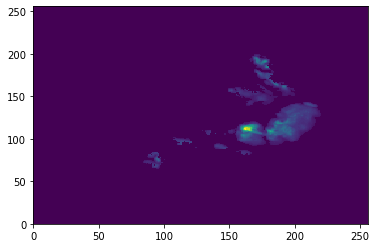

In [41]:
#True output:
plt.pcolormesh(Y_total[20,:,:])

In [42]:
X_training = np.swapaxes(X_training,0,1)
X_training = np.swapaxes(X_training,1,3)
X_validation = np.swapaxes(X_validation,0,1)
X_validation = np.swapaxes(X_validation,1,3)
X_testing = np.swapaxes(X_testing,0,1)
X_testing = np.swapaxes(X_testing,1,3)
X_total = np.swapaxes(X_total,0,1)
X_total = np.swapaxes(X_total,1,3)
X_testing.shape

(3, 256, 256, 3)

In [43]:
Y_training = np.swapaxes(Y_training,1,2)
Y_validation = np.swapaxes(Y_validation,1,2)
Y_testing = np.swapaxes(Y_testing,1,2)
Y_total = np.swapaxes(Y_total,1,2)
Y_testing.shape

(3, 256, 256)

In [45]:
Y_total.max()

0.04322

In [33]:
#Log it because of rarity of events
np.where(Y_training==0, 1e-10, Y_training) 
Y_training = np.log10(Y_training)
np.where(Y_validation==0, 1e-10, Y_validation) 
Y_validation = np.log10(Y_validation)
np.where(Y_testing==0, 1e-10, Y_testing) 
Y_testing = np.log10(Y_testing)
np.where(Y_total==0, 1e-10, Y_total)
Y_total = np.log10(Y_total)

<ipython-input-33-f245be9d6125>:3: RuntimeWarning: divide by zero encountered in log10
  Y_training = np.log10(Y_training)
<ipython-input-33-f245be9d6125>:5: RuntimeWarning: divide by zero encountered in log10
  Y_validation = np.log10(Y_validation)
<ipython-input-33-f245be9d6125>:7: RuntimeWarning: divide by zero encountered in log10
  Y_testing = np.log10(Y_testing)
<ipython-input-33-f245be9d6125>:9: RuntimeWarning: divide by zero encountered in log10
  Y_total = np.log10(Y_total)


In [35]:
Y_total

array([[[-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],

       [[-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],

       [[-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        ...,
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf],
        [-inf, -inf, -inf, ..., -inf, -inf, -inf]],

       ...,

       [[-inf, -inf, -in

## Making the U-Net

documentation: https://github.com/yingkaisha/keras-unet-collection

In [11]:
#Unet = convolutional neural net
#Downscales an image several times to extract features of various sizes
#Upscales it back to an image of the original size

In [12]:
#making a basic unet
# image_size -- length by width by channels used to predict the outcome (like CAPE, refc, ...), time will be batch-size which comes in in the generator
# filter_num --  ex: [32,64,128,256,512,1024], but I think these will be proportional to original image size
# num_labels -- number of targets we are trying to predict = 1
# stack_num_down -- number of layers we go down (he did 5)
# stack_num_up -- number of layers we go up (he did 5)
# activation -- activation function in the hidden layers
# output_activation -- activation function for the output layer
# batch_norm -- scales arrays to a common scale, we usually want this on to keep units from having too much of an effect
# pool -- how do you want to pool the data during downscaling? True = max
# unpool -- how do you want to interpolate during upscaling? True = ??
# name -- name for the layers when summary function is called


model = models.unet_2d((256,256,3),
                       filter_num = [64,128], #[112,224,448,896,1792],
                       n_labels = 1,
                       stack_num_down = 1,
                       stack_num_up = 1,
                       activation = 'LeakyReLU',
                       output_activation = 'ReLU',
                       batch_norm = True,
                       pool = True,
                       unpool = True,
                       name = 'unet')

In [13]:
#compiling a unet
#unets use gradient descent
#Adam is an optimizer for the model which is a gradient descent replacemtne
# learning_rate - how fast does the model learn? Too high, the model will finish training before it's actually learned, too slow is inefficient
# start learning with 10^-4, 10^-3, 10^-5
# loss function measure the error between the predicted value and the truth value. Error should go down durring training
# metrics could be AUC or accuracy - Andrew doesn't worry about this one. Doesn't affect the model, just affects the model output

learning_rate = 1e-4
loss_function = keras.losses.MeanSquaredError()     #loss_function = 'tversky' # could be 'dice', 'tversky', 'categorical_crossentropy', probably more too

adam = Adam(learning_rate=learning_rate)
model.compile(loss=loss_function, optimizer=adam, metrics=tf.keras.metrics.Accuracy()) #Accurracy

In [14]:
#print out the model
model.summary()

#the first output dimension will say "None" because it's the batch size and it's not declared

Model: "unet_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
unet_down0_0 (Conv2D)           (None, 256, 256, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
unet_down0_0_bn (BatchNormaliza (None, 256, 256, 64) 256         unet_down0_0[0][0]               
__________________________________________________________________________________________________
unet_down0_0_activation (LeakyR (None, 256, 256, 64) 0           unet_down0_0_bn[0][0]            
_________________________________________________________________________________________

In [15]:
#fit the model

#validation frequency = how many epochs should it go in between training and tweaking the model
#epochs = number of times it runs over your dataset
#batch_size = number of items in the training dataset ||| steps_per_epoch if using a generator
#validation_steps = same thing as steps per epoch but during validation
#callbacks = extra setting for the model - like model checkpoint, early stopping
    #tf.keras.callbacks.ModelCheckpoint - probably want to use this - saves the model periodically - usually moniter the loss function, save_best_only = True
    #early stopping = EarlyStopping('loss',patience=500,verbose=2) - will stop the model when it starts to perform badly on the validation data
#workers = how many threads=CPU to use to train batches in parallel (=2)? based on hardware
#use_multiprocessing=True
#max_queue_size=100000 - the queue holds the batches if the GPU gets backed up
    
#trained_model = model.fit(train_dataset.repeat(),
#                    validation_data=validation_dataset.repeat())

#'''
#X_training = np.swapaxes(X_training,0,2)
#Y_training = np.swapaxes(Y_training,0,2)

early_stopping = EarlyStopping('loss',patience=500,verbose=2)
checkpoint = tf.keras.callbacks.ModelCheckpoint('unet_test_data/model_test', monitor='loss', verbose=1, save_best_only=True, save_weights_only=False, save_freq='epoch')

trained_model = model.fit(X_total,
                          Y_total,
                          validation_freq=5,
                          epochs=20,
                          batch_size=23, #steps_per_epoch=23,
                          validation_steps=5,
                          callbacks=[early_stopping, checkpoint],
                          verbose=2,
                          workers=2,
                          use_multiprocessing=True,
                          max_queue_size=100)    #'''
#model.fit?

Epoch 1/20
1/1 - 46s - loss: inf - accuracy: 0.0000e+00

Epoch 00001: loss did not improve from inf
Epoch 2/20
1/1 - 31s - loss: nan - accuracy: 0.0000e+00

Epoch 00002: loss did not improve from inf
Epoch 3/20
1/1 - 31s - loss: nan - accuracy: 0.0000e+00

Epoch 00003: loss did not improve from inf
Epoch 4/20
1/1 - 30s - loss: nan - accuracy: 0.0000e+00

Epoch 00004: loss did not improve from inf
Epoch 5/20
1/1 - 33s - loss: nan - accuracy: 0.0000e+00

Epoch 00005: loss did not improve from inf
Epoch 6/20
1/1 - 27s - loss: nan - accuracy: 0.0000e+00

Epoch 00006: loss did not improve from inf
Epoch 7/20
1/1 - 30s - loss: nan - accuracy: 0.0000e+00

Epoch 00007: loss did not improve from inf
Epoch 8/20
1/1 - 31s - loss: nan - accuracy: 0.0000e+00

Epoch 00008: loss did not improve from inf
Epoch 9/20
1/1 - 32s - loss: nan - accuracy: 0.0000e+00

Epoch 00009: loss did not improve from inf
Epoch 10/20
1/1 - 40s - loss: nan - accuracy: 0.0000e+00

Epoch 00010: loss did not improve from inf

In [16]:
X_testing.shape

(3, 256, 256, 3)

In [17]:
output = 10**model.predict(X_total)

In [18]:
output.shape

(23, 256, 256, 1)

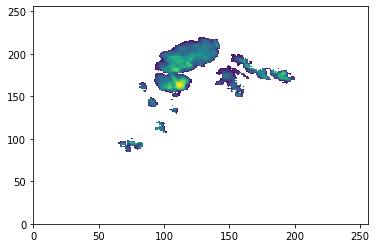

In [19]:
#True hail
plt.pcolormesh(Y_total[20,:,:])

<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
C:\Users\lkspy\anaconda3\envs\hagelslag\lib\site-packages\numpy\core\_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


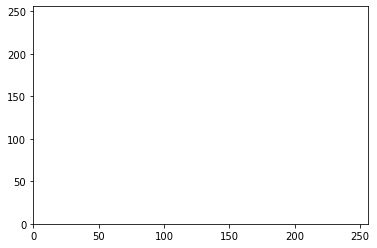

In [20]:
#ML output
plt.pcolormesh(output[20,:,:,0])

#### data generators

In [ ]:
#DataGenerators are classes/object
class DataGenerator(keras.utils.sequence):
    def __init__(self,...): #this is a constructor
                #when the generator is called, this is the (constructor sort of?)
                #this is where we feed in the batch size
    
    def __len__(self,...):
    
    def __getitem__(self,...):
        input, output = self.__data_generation
        return input, output#returns the data to the GPU to be trained - final step of the generator
                  
    def __data_generation(self,...):

tf.data.Dataset.from_generator(DataGenerator, args=[], output_types=(tf.float64,tf.float64))

In [ ]:
input_ds.latitude

In [ ]:
refc_training.shape

In [ ]:
#Commonly used hyperparameter list from the models example file:
#size of the input tensors
input_size = refc_training.shape    

#number of convolutional filters per down- and up-sampling blocks (these are the values they had in the example)
filter_num = [64,128,256,512]

#number of output targets (the 90th percentile of hail)
n_labels = 1

#activation function: 'ReLU', 'LeakyReLU', 'PReLU', 'ELU', 'GELU', 'Snake'
activation = 'LeakyReLU'

#activation choices for the output layer
output_activation = 'ReLU'


#going with the default values of the following:
#batch_norm = #T/F batch_normalization?
#stack_num_down = #number of convolutional layers per downsampling layer
#stack_num_up = #number of convolutional layers per upsampling layer
#pool = #False - downsampling with a convolutional layer, True or 'max' - downsampling with max-pooling layer, 'ave' - downsampling with a average-pooling layer
#unpool = #False - upsampling with a transpose convolutional layer, True or 'bilinear' - upsampling with bilinear interpolation, 'nearest' - upsampling with reflective padding
#name = #user-specified prefix of the configured layer and model


In [ ]:
#Create the ML model
#attention u-net is the one that was regression in the readme file
model = models.att_unet_2d(input_size,
                       filter_num,
                       n_labels,
                       activation=activation,
                       output_activation=output_activation)

In [ ]:
model.compile?

In [ ]:
print(refc_training.shape)
print(hail_training.shape)

In [ ]:
model.compile()
model.fit(refc_training, hail_training)